In [1]:
# Copyright 2021 The ASReview Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# imports
import os
from tqdm import tqdm
from dim_reduct import run_pca
from dim_reduct import t_sne
from clustering import run_KMeans
from asreview.data import ASReviewData
import numpy as np
from transformers import AutoTokenizer, AutoModel
from transformers import logging
import matplotlib.pyplot as plt
import seaborn as sns
logging.set_verbosity_error()
sns.set()
tqdm.pandas()


In [2]:
def visualize_clusters(data, labels):
    fig, ax = plt.subplots()
    ax.set_title("semantic clustering")
    ax.set_xlabel("t-SNE Component 1")
    ax.set_ylabel("t-SNE Component 2")

    x = data[0]
    y = data[1]

    # Do actual plotting and save image
    ax.scatter(x, y, c=labels, cmap="Set3")
    if not os.path.exists("img"):
        os.makedirs("img")
    filename = "clusters.png"
    img_path = os.path.join("img", filename)
    fig.savefig(img_path)

In [3]:
def load_data(asreview_data_object):

    # extract title and abstract, drop empty abstracts and reset index
    data = asreview_data_object.df[['title', 'abstract']].copy()
    data['abstract'] = data['abstract'].replace('', np.nan, inplace=False)
    data.dropna(subset=['abstract'], inplace=True)
    data = data.reset_index(drop=True)

    return data

In [5]:
# load data
print("Loading data...")
filepath = "https://raw.githubusercontent.com/asreview/systematic-review-datasets/master/datasets/van_de_Schoot_2017/output/van_de_Schoot_2017.csv"
data = load_data(ASReviewData.from_file(filepath))

# cut data for testing
data = data.iloc[:100, :]

# load scibert transformer
print("Loading scibert transformer...")
transformer = 'allenai/scibert_scivocab_uncased'

# load transformer and tokenizer
print("Loading tokenizer and model...")
tokenizer = AutoTokenizer.from_pretrained(transformer)
model = AutoModel.from_pretrained(transformer)

Loading data...
Loading scibert transformer...
Loading tokenizer and model...


In [9]:
# tokenize abstracts and add to data
print("Tokenizing abstracts...")
data['tokenized'] = data['abstract'].progress_apply(lambda x: tokenizer.encode_plus(
    x,
    add_special_tokens=False,
    truncation=True,
    max_length=512,
    padding='max_length',
    return_tensors='pt'))

Tokenizing abstracts...


100%|██████████| 100/100 [00:00<00:00, 1166.69it/s]


In [10]:
# generate embeddings and format correctly
print("Generating embeddings...")
data['embeddings'] = data['tokenized'].progress_apply(lambda x: model(
    **x,
    output_hidden_states=False)[-1].detach().numpy().squeeze())

Generating embeddings...


100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


In [12]:
# run pca
print("Running PCA...")
pca = run_pca(data['embeddings'].tolist(), n_components=.98)

# run t-sne
print("Running t-SNE...")
tsne = t_sne(pca, n_iter=1000)

# run k-means
print("Running k-means...")
labels = run_KMeans(tsne, 10, 10)


Running PCA...
Running t-SNE...
Running k-means...


In [22]:
tsne_data = [tsne[:, 0], tsne[:, 1]]

Visualizing clusters...


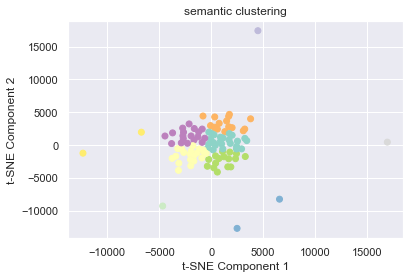

In [26]:

# visualize clusters
print("Visualizing clusters...")
visualize_clusters(tsne_data, labels)